In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget
import os
print(os.path.exists(r"C:\Users\kaushikl\OneDrive - University of Maryland\UMD\Project_Research\SNN Training (Izh)\backpropizh\snntorch"))

import sys
sys.path.insert(0, r"C:\Users\kaushikl\OneDrive - University of Maryland\UMD\Project_Research\SNN Training (Izh)\backpropizh\snntorch")

import importlib
import snntorch
importlib.reload(snntorch)

#print(snn.__file__)

import torch
import torchdata
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import snntorch as snn
import snntorch.spikeplot as splt
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import _neurons
from snntorch import utils
from snntorch import spikegen

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display, update_display
from ipywidgets import IntProgress
from tabulate import tabulate

import brevitas
import brevitas.nn as qnn

True


In [2]:
train_transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

test_transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

data_path='./data/mnist'

train_set = datasets.MNIST(data_path, train=True, download=True, transform=train_transform)
test_set = datasets.MNIST(data_path, train=False, download=True, transform=test_transform)

In [3]:
class BatchPlotter:
    def __init__(self, batches_per_epoch):
        self.batches_per_epoch = batches_per_epoch
        self.fig, self.ax = plt.subplots(figsize=(10, 5))
        self.x_data, self.loss_data, self.acc_data, self.conf_data = [], [], [], []
        self.setup()

    def setup(self):
        self.display_handle = None
        self.loss_line, = self.ax.plot([], [], 'r-', label='Loss')
        self.ax2 = self.ax.twinx()
        self.acc_line, = self.ax2.plot([], [], 'b-', label='Accuracy')
        self.conf_line, = self.ax2.plot([], [], 'g-', label='Confidence')
        
        self.ax.set_xlabel(f'Batch ({self.batches_per_epoch} per Epoch)')
        self.ax.set_ylabel('Loss')
        self.ax2.set_ylabel('Accuracy & Confidence')
        
        lines, labels = self.ax.get_legend_handles_labels()
        lines2, labels2 = self.ax2.get_legend_handles_labels()

    def update(self, epoch_idx, batch_idx, loss, acc, conf):
        self.fig.suptitle(f'Training Progress ({epoch_idx} Epochs)')
        current_index = epoch_idx * self.batches_per_epoch + batch_idx
        self.x_data.append(current_index)
        self.loss_data.append(loss)
        self.acc_data.append(acc)
        self.conf_data.append(conf)
    
        self.loss_line.set_data(self.x_data, self.loss_data)
        self.acc_line.set_data(self.x_data, self.acc_data)
        self.conf_line.set_data(self.x_data, self.conf_data)
    
        if batch_idx == 0:
            self.ax2.axvline(x=current_index, color='gray', linestyle='--', linewidth=1, label='Epoch boundary' if epoch_idx == 0 else "")
    
        if epoch_idx == 0 and batch_idx == 0:
            lines, labels = self.ax.get_legend_handles_labels()
            lines2, labels2 = self.ax2.get_legend_handles_labels()
            self.ax.legend(lines + lines2, labels + labels2, loc='upper left')
    
        self.ax.relim()
        self.ax.autoscale_view()
        self.ax2.relim()
        self.ax2.autoscale_view()
    
        if self.display_handle is None:
            self.display_handle = display(self.fig, display_id=True)
        else:
            update_display(self.fig, display_id=self.display_handle.display_id)

    def close(self):
        plt.close(self.fig)

In [4]:
class Trainer:
    def __init__(self, model, config):
        self.model = model
        self.config = config
        self.device = config['device']
        self.optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=config['patience'])
        self.train_loader = DataLoader(config['train_set'], batch_size=config['batch_size'], shuffle=True, drop_last=True)
        self.test_loader = DataLoader(config['test_set'], batch_size=config['batch_size'], shuffle=False, drop_last=True)
        self.loss_fn = config['loss_fn']
        self.train_stats = config['train_stats']
        self.test_stats = config['test_stats']
        self.num_steps = config['num_steps']
        self.l1_lambda = config['l1_lambda']
        self.num_epochs = config['num_epochs']

    def forward_pass(self, net, data):
        utils.reset(net)
        spk_rec = []
        num_steps = data.size(0)
        for step in range(num_steps):
            spk_out, mem_out, *args = net(data[step])
            spk_rec.append(spk_out)
        return torch.stack(spk_rec)

    def to_spikes(self, data, num_steps):
        return spikegen.rate(data, num_steps=num_steps, gain=1).view(num_steps, data.size(0), -1)

    def count_accuracy(self, spk_out, targets):
        spike_count = spk_out.sum(dim=0).float()
        probabilities = torch.nn.functional.softmax(spike_count, dim=-1)
        confidence, idx = probabilities.max(1)
        accuracy = np.mean((targets == idx).detach().cpu().numpy())
        mean_confidence = confidence.mean().item()
        return accuracy, mean_confidence

    def l1_regularization(self, model, l1_lambda):
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        return l1_lambda * l1_norm

    def print_lr_if_changed(self, scheduler, last_lr):
        current_lr = scheduler.get_last_lr()[0]
        if current_lr != last_lr:
            print(f"Learning rate changed to: {current_lr:.6f}")
        return current_lr

    def validate(self):
        self.model.eval()
        total_loss = 0
        total_acc = 0
        total_conf = 0
        num_batches = 0
        
        with torch.no_grad():
            for data, labels in self.test_loader:
                data, labels = self.to_spikes(data, self.num_steps).to(self.device), labels.to(self.device)
                spikes = self.forward_pass(self.model, data)
                loss_val = self.loss_fn(spikes, labels)
                acc, conf = self.count_accuracy(spikes, labels)
                total_loss += loss_val.item()
                total_acc += acc
                total_conf += conf
                num_batches += 1
        
        loss = total_loss / num_batches
        acc = total_acc / num_batches
        conf = total_conf / num_batches
        return loss, acc, conf

    def train(self):
        plotter = BatchPlotter(len(self.train_loader))
        last_lr = self.optimizer.param_groups[0]['lr']
        for epoch in range(self.num_epochs):
            total_loss, total_acc, total_conf, num_batches = 0, 0, 0, 0
            for batch, (data, labels) in enumerate(self.train_loader):
                data, labels = self.to_spikes(data, self.num_steps).to(self.device), labels.to(self.device)
                self.model.train()
                self.optimizer.zero_grad()
                spikes = self.forward_pass(self.model, data)
                loss_val = self.loss_fn(spikes, labels)
                if self.l1_lambda > 0:
                    l1_penalty = self.l1_regularization(self.model, self.l1_lambda)
                    loss_val += l1_penalty
                loss_val.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()

                loss = loss_val.item()
                acc, conf = self.count_accuracy(spikes, labels)
                plotter.update(epoch, batch, loss, acc, conf)
                self.train_stats.loc[len(self.train_stats)] = {"epoch": epoch, "batch": batch, "acc": acc}
                total_loss += loss_val.item()
                total_acc += acc
                total_conf += conf
                num_batches += 1

            train_loss, train_acc, train_conf = total_loss / num_batches, total_acc / num_batches, total_conf / num_batches
            test_loss, test_acc, test_conf = self.validate()
    
            if self.scheduler:
                self.scheduler.step(test_loss)
                last_lr = self.print_lr_if_changed(self.scheduler, last_lr)

            self.test_stats.loc[len(self.test_stats)] = {"epoch": epoch, "acc": test_acc}
    
            # Print epoch-level stats
            table = [
                [f"Epoch {epoch:2d}", "Loss", "Accuracy", "Confidence"],
                ["Training", f"{train_loss:.4f}", f"{train_acc:.4f}", f"{train_conf:.4f}"],
                ["Testing", f"{test_loss:.4f}", f"{test_acc:.4f}", f"{test_conf:.4f}"]
            ]
            print(tabulate(table, headers="firstrow", tablefmt="grid"))




In [5]:
def gen_seq_model(topo, neuron_layer, neuron_params={}, bias=False, quant_weights=False, quant_states=False):
    state_quant = SF.quant.state_quant(num_bits=8, uniform=True, thr_centered=False) if quant_states else None
    layers = []

    neuron_layer_classes = {
        'NormIzh': snn.NormIzh,
        'Leaky': snn.Leaky,
    }

    if neuron_layer not in neuron_layer_classes:
        raise ValueError(f"Invalid neuron_layer '{neuron_layer}'. Available options: {list(neuron_layer_classes.keys())}")

    neuron_class = neuron_layer_classes[neuron_layer]

    for i in range(len(topo) - 1):
        if quant_weights:
            layers.append(qnn.QuantLinear(
                topo[i], topo[i + 1], bias=bias,
                weight_quant=brevitas.quant.Int8WeightPerTensorFixedPoint, weight_bit_width=4))
        else:
            layers.append(nn.Linear(topo[i], topo[i + 1], bias=bias))

        if i < len(topo) - 2:
            layers.append(neuron_class(init_hidden=True, state_quant=state_quant, **neuron_params))

    layers.append(neuron_class(init_hidden=True, output=True, state_quant=state_quant, **neuron_params))

    return nn.Sequential(*layers)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =", device)

snn.SpikingNeuron.init()

topo = [784, 512, 10] # 784 input neurons, 512 hidden neurons, 10 output neurons
# topo = [2, 4, 4, 2] # 2 input neurons, 4 hidden neurons, 4 hidden neu rons, 2 output neurons

izh_model = gen_seq_model(
    topo=topo,
    neuron_layer='NormIzh',
    neuron_params={'neuron_type': 'RS'},
    bias=True,
    quant_weights=False,
    quant_states=False,
).to(device)

lif_model = gen_seq_model(
    topo=topo,
    neuron_layer='Leaky',
    neuron_params={'beta': 0.9},
    bias=True,
    quant_weights=False,
    quant_states=False,
).to(device).to(device)

device = cpu
Added NormIzh() to instances: [NormIzh()].
Added NormIzh() to instances: [NormIzh(), NormIzh()].
Added Leaky() to instances: [NormIzh(), NormIzh(), Leaky()].
Added Leaky() to instances: [NormIzh(), NormIzh(), Leaky(), Leaky()].


In [7]:
izh_train_stats  = pd.DataFrame(columns=["epoch", "batch", "acc",])
izh_test_stats = pd.DataFrame(columns=["epoch", "acc",])

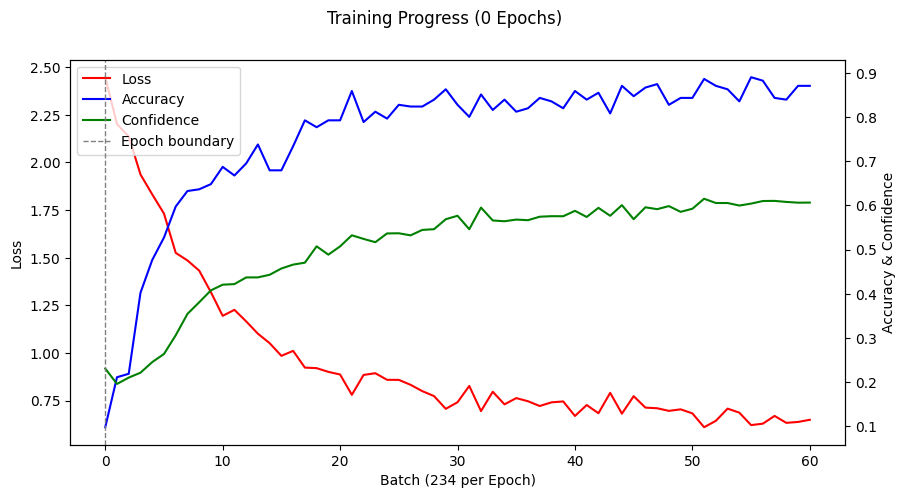

KeyboardInterrupt: 

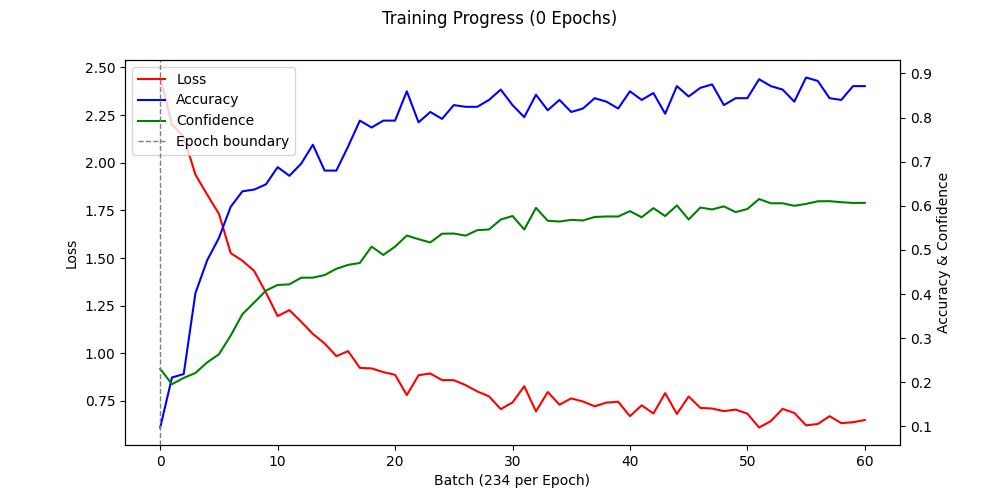

In [8]:
izh_train_config = {
    "batch_size": 256,
    "train_set": train_set,
    "test_set": test_set,
    "num_steps": 8,
    "learning_rate": 5e-4,
    "patience": 20,
    "weight_decay": 0,
    "l1_lambda": 0,
    "num_epochs": 10,
    "device": device,
    "loss_fn": SF.ce_count_loss(),
    "train_stats": izh_train_stats,
    "test_stats": izh_test_stats,
}

izh_trainer = Trainer(izh_model, izh_train_config)
izh_trainer.train()
izh_train_stats.to_csv("./izh_train_stats.csv")
izh_test_stats.to_csv("./izh_test_stats.csv")